# Traditional Classifiers

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import StandardScaler

from recurrent_health_events_prediction.training.utils import plot_permutation_importance
from recurrent_health_events_prediction.training.utils import summarize_search_results


In [2]:
import yaml
from importlib import resources as impresources
from recurrent_health_events_prediction import configs

with open((impresources.files(configs) / 'model_config.yaml')) as f:
    model_config = yaml.safe_load(f)
with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

In [3]:
training_data_config = data_config["training_data"]["mimic"]

In [4]:
training_data_config

{'preprocessed_path': '/workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure',
 'admission_types_to_consider': None,
 'default_time_censoring': 60,
 'thresold_censoring_estimation': 100,
 'filters': {'AGE': {'min': 18, 'max': 100},
  'HOSPITALIZATION_DAYS': {'max': 180}},
 'clip_features': {'HOSPITALIZATION_DAYS': {'min': 0.5}},
 'log_features_to_add': ['HOSPITALIZATION_DAYS',
  'DAYS_IN_ICU',
  'DAYS_UNTIL_NEXT_HOSPITALIZATION',
  'DAYS_SINCE_LAST_HOSPITALIZATION',
  'NUM_PREV_HOSPITALIZATIONS',
  'DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
  'DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN']}

## Import Data

In [5]:
EXCLUDE_ELECTIVE = True
SELECT_ONLY_ONE_EVENT_PER_PATIENT = True
SELECT_PATIENTS_WITH_MORE_PREV_HOSP = False
MIN_PREV_HOSP = 2  # minimum number of prev hospitalizations for a patient to be selected
SELECT_DISEASE = False
#OBSERVATION_WINDOW = 30  # days
SELECT_ONLY_PATIENTS_WITH_KNOWN_RETURN = False  # if True, patients who never returned after the last event are disconsidered
skip_filtering = False  # if True, skip filtering of the dataset based on the conditions above

MULTICLASS_ANALYSIS = False  # if True, the target is a multiclass variable, otherwise it is binary

target_col = "READMISSION_30_DAYS"

In [6]:
#training_data_path = training_data_config["preprocessed_path"]
training_data_path = "/workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/multiple_hosp_patients"
file_path = training_data_path + "/last_events.csv"
print(f"Loading last events from {file_path}")
last_events_df = pd.read_csv(file_path)

Loading last events from /workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/multiple_hosp_patients/last_events.csv


In [7]:
last_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 55 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SUBJECT_ID                            1690 non-null   int64  
 1   HADM_ID                               1690 non-null   int64  
 2   ADMITTIME                             1690 non-null   object 
 3   DISCHTIME                             1690 non-null   object 
 4   ADMISSION_TYPE                        1690 non-null   object 
 5   ETHNICITY                             1690 non-null   object 
 6   INSURANCE                             1690 non-null   object 
 7   HOSPITALIZATION_DAYS                  1690 non-null   float64
 8   NUM_COMORBIDITIES                     1690 non-null   int64  
 9   TYPES_COMORBIDITIES                   1690 non-null   object 
 10  HAS_DIABETES                          1690 non-null   bool   
 11  HAS_COPD         

In [8]:
if not skip_filtering:
    if EXCLUDE_ELECTIVE:
        last_events_df = last_events_df[last_events_df["NEXT_ADMISSION_TYPE"] != "ELECTIVE"]
    if SELECT_ONLY_ONE_EVENT_PER_PATIENT:
        # Select only the first event for each subject
        # This is done to avoid multiple events for the same subject in the training data
        # which can lead to overfitting and biased predictions.
        last_events_df = last_events_df.sort_values(['SUBJECT_ID', 'ADMITTIME']).groupby('SUBJECT_ID', as_index=False).first()
    if SELECT_PATIENTS_WITH_MORE_PREV_HOSP:
        last_events_df = last_events_df[last_events_df["NUM_PREV_HOSPITALIZATIONS"] >= MIN_PREV_HOSP]
    if SELECT_ONLY_PATIENTS_WITH_KNOWN_RETURN:
        last_events_df = last_events_df[~last_events_df["DAYS_UNTIL_NEXT_HOSPITALIZATION"].isna()]
    else:
        last_events_df["READMISSION_30_DAYS"].fillna(False, inplace=True)
    if SELECT_DISEASE:
        disease_mask = (last_events_df['HAS_COPD'] | last_events_df['HAS_CONGESTIVE_HF'])
        print("Num of prev rows last events dataframe: ", len(last_events_df))
        last_events_df = last_events_df[disease_mask]
        print("Num of rows last events dataframe after filtering: ", len(last_events_df))

/tmp/ipykernel_54233/935397607.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  last_events_df["READMISSION_30_DAYS"].fillna(False, inplace=True)


In [9]:
print("Final number of unique subjects: ", last_events_df.SUBJECT_ID.nunique())
print("Final number of events: ", len(last_events_df))

Final number of unique subjects:  1690
Final number of events:  1690


In [10]:
# Add a random feature for reference
np.random.seed(42)  # Ensure reproducibility
last_events_df['RANDOM_FEATURE'] = np.random.rand(len(last_events_df))

last_events_df['FIRST_HOSPITALIZATION'] = (last_events_df['NUM_PREV_HOSPITALIZATIONS'] == 0).astype(int)

In [11]:
last_events_df[["SUBJECT_ID", "DAYS_UNTIL_NEXT_HOSPITALIZATION", "READMISSION_30_DAYS"]].head(10)

,SUBJECT_ID,DAYS_UNTIL_NEXT_HOSPITALIZATION,READMISSION_30_DAYS
0,107,160.221528,0
1,109,12.063194,1
2,236,1361.902778,0
3,249,438.179167,0
4,256,49.901389,0
5,291,512.313194,0
6,305,766.170139,0
7,323,96.872222,0
8,339,NaN,0
9,353,616.204861,0


## Train-Test Split

In [12]:
# Exclude target, keep subject ID for debugging
cols = last_events_df.columns.to_list()
cols.remove(target_col)

train_set_df, test_set_df, y_train, y_test = train_test_split(last_events_df[cols], last_events_df[target_col],
                                   test_size=0.2, random_state=42,
                                   stratify=last_events_df[target_col])

features_to_scale = ["LOG_NUM_PREV_HOSPITALIZATIONS", "LOG_NUM_PREV_HOSPITALIZATIONS",
                     "LOG_HOSPITALIZATION_DAYS", "LOG_DAYS_IN_ICU", "READM_30_DAYS_PAST_MEAN",
                     "READM_30_DAYS_PAST_SUM",
                     "NUM_COMORBIDITIES", "NUM_PROCEDURES", "CHARLSON_INDEX", "AGE", "NUM_DRUGS",
                     "LOG_DAYS_SINCE_LAST_HOSPITALIZATION", "LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN", "RANDOM_FEATURE"]

train_set_scaled_df = train_set_df.copy()
test_set_scaled_df = test_set_df.copy()

scaler = StandardScaler()

train_set_scaled_df[features_to_scale] = scaler.fit_transform(train_set_df[features_to_scale])
test_set_scaled_df[features_to_scale] = scaler.transform(test_set_df[features_to_scale])

print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Class distribution in training set:
READMISSION_30_DAYS
0    0.751479
1    0.248521
Name: proportion, dtype: float64

Class distribution in test set:
READMISSION_30_DAYS
0    0.751479
1    0.248521
Name: proportion, dtype: float64


## Select Features

In [13]:
features = ['AGE', 'CHARLSON_INDEX', 'LOG_HOSPITALIZATION_DAYS',
            'LOG_NUM_PREV_HOSPITALIZATIONS', 'LOG_DAYS_IN_ICU',
            'NUM_DRUGS', 'NUM_PROCEDURES', 'NUM_COMORBIDITIES',
            'PREV_READMISSION_30_DAYS', 
            'HAS_DIABETES', 'HAS_COPD', "RANDOM_FEATURE"]

In [14]:
X_train = train_set_df[features]
X_test = test_set_df[features]

X_train_scaled = train_set_scaled_df[features]
X_test_scaled = test_set_scaled_df[features]

In [15]:
from scipy.stats import spearmanr

# Calculate Spearman correlation for each feature
spearman_correlations = {}
for feature in X_train_scaled.columns:
    correlation, _ = spearmanr(X_train_scaled[feature], y_train)
    spearman_correlations[feature] = correlation

corr_df = pd.DataFrame.from_dict(spearman_correlations, orient='index', columns=['Spearman Correlation Readmission']).sort_values(by='Spearman Correlation Readmission', ascending=False)
corr_df.reset_index(names='Feature', inplace=True)
print(corr_df)

                          Feature  Spearman Correlation Readmission
0        PREV_READMISSION_30_DAYS                          0.159184
1                 LOG_DAYS_IN_ICU                          0.120490
2                  CHARLSON_INDEX                          0.074513
3   LOG_NUM_PREV_HOSPITALIZATIONS                          0.063684
4                             AGE                          0.058546
5                       NUM_DRUGS                          0.050489
6               NUM_COMORBIDITIES                          0.048973
7                  NUM_PROCEDURES                          0.044178
8                    HAS_DIABETES                          0.023726
9        LOG_HOSPITALIZATION_DAYS                          0.006179
10                       HAS_COPD                         -0.012488
11                 RANDOM_FEATURE                         -0.036832


In [16]:
from scipy.stats import pointbiserialr
# Calculate Spearman correlation for each feature
biserial_correlations = {}
for feature in X_train_scaled.columns:
    correlation, _ = pointbiserialr(X_train_scaled[feature], y_train)
    biserial_correlations[feature] = correlation

corr_df = pd.DataFrame.from_dict(biserial_correlations, orient='index', columns=['Biserial Correlation Readmission']).sort_values(by='Biserial Correlation Readmission', ascending=False)
corr_df.reset_index(names='Feature', inplace=True)
print(corr_df)

                          Feature  Biserial Correlation Readmission
0        PREV_READMISSION_30_DAYS                          0.159184
1                 LOG_DAYS_IN_ICU                          0.131706
2                  CHARLSON_INDEX                          0.078942
3   LOG_NUM_PREV_HOSPITALIZATIONS                          0.076221
4                       NUM_DRUGS                          0.066941
5                  NUM_PROCEDURES                          0.060714
6               NUM_COMORBIDITIES                          0.051081
7                             AGE                          0.041924
8                    HAS_DIABETES                          0.023726
9        LOG_HOSPITALIZATION_DAYS                          0.019100
10                       HAS_COPD                         -0.012488
11                 RANDOM_FEATURE                         -0.037208


In [17]:
from sklearn.decomposition import PCA

# Select the features for PCA
pca_features = features

# Perform PCA
pca = PCA(n_components=5)  # Reduce to 4 principal components
X_pca_train = pca.fit_transform(train_set_scaled_df[pca_features])
X_pca_test = pca.transform(test_set_scaled_df[pca_features])

# Display explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Create a DataFrame for the transformed data
X_pca_train = pd.DataFrame(X_pca_train, columns=["PC" + str(i) for i in range(pca.n_components_)])
X_pca_test = pd.DataFrame(X_pca_test, columns=["PC" + str(i) for i in range(pca.n_components_)])

Explained variance ratio: [0.28997023 0.20827079 0.11822256 0.10285335 0.08522625]


## Models

In [18]:
print("Features used in the model:", features)

Features used in the model: ['AGE', 'CHARLSON_INDEX', 'LOG_HOSPITALIZATION_DAYS', 'LOG_NUM_PREV_HOSPITALIZATIONS', 'LOG_DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES', 'NUM_COMORBIDITIES', 'PREV_READMISSION_30_DAYS', 'HAS_DIABETES', 'HAS_COPD', 'RANDOM_FEATURE']


In [19]:
scoring_search_cv = 'roc_auc' if not MULTICLASS_ANALYSIS else 'roc_auc_ovr'

### Logistic Regression

In [ ]:
param_dist_logreg = {
    'C': np.logspace(-4, 4, 100),  # 100 values between 1e-4 and 1e4
    'penalty': ['l2', 'l1'], # 'l1' if solver supports it
    'class_weight': ['balanced'],
    'solver': ['liblinear'],  # 'saga' supports 'l1' penalty
}

logreg_model = LogisticRegression()

random_search_logreg = RandomizedSearchCV(
    logreg_model,
    param_distributions=param_dist_logreg,
    n_iter=25,  # or any number of random samples you want
    scoring=scoring_search_cv,
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search_logreg.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=25, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.9...
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                                        'class_weight': ['balanced'],
                                        'max_iter': [1000],
                                        'penalty': ['l2', 'l1'],
                                        'random_state': [42],
                                        'solver': ['liblinear']},
                   random_state=42, scoring='roc_auc')

In [21]:
logreg_cv_search_results = summarize_search_results(random_search_logreg, print_results=True, model_name="Logistic Regression")

25 candidates of Logistic regression trained and validated with cross-validation on 5 folds.
Best parameters: {'solver': 'liblinear', 'random_state': 42, 'penalty': 'l2', 'max_iter': 1000, 'class_weight': 'balanced', 'C': np.float64(10.235310218990268)}
Validation Score - Logistic regression: 0.637 ± 0.027


In [22]:
from sklearn.metrics import roc_auc_score

y_pred = random_search_logreg.predict(X_test_scaled)
y_pred_proba = random_search_logreg.predict_proba(X_test_scaled)[:, 1]

roc_auc_logreg = roc_auc_score(y_test, y_pred_proba)

print("Logistic Regression model evaluation:")
print("AUC:", roc_auc_score(y_test, y_pred_proba, multi_class='ovr' if MULTICLASS_ANALYSIS else 'raise'))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression model evaluation:
AUC: 0.5978627671541057
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.63      0.70       254
           1       0.31      0.51      0.39        84

    accuracy                           0.60       338
   macro avg       0.55      0.57      0.54       338
weighted avg       0.67      0.60      0.62       338



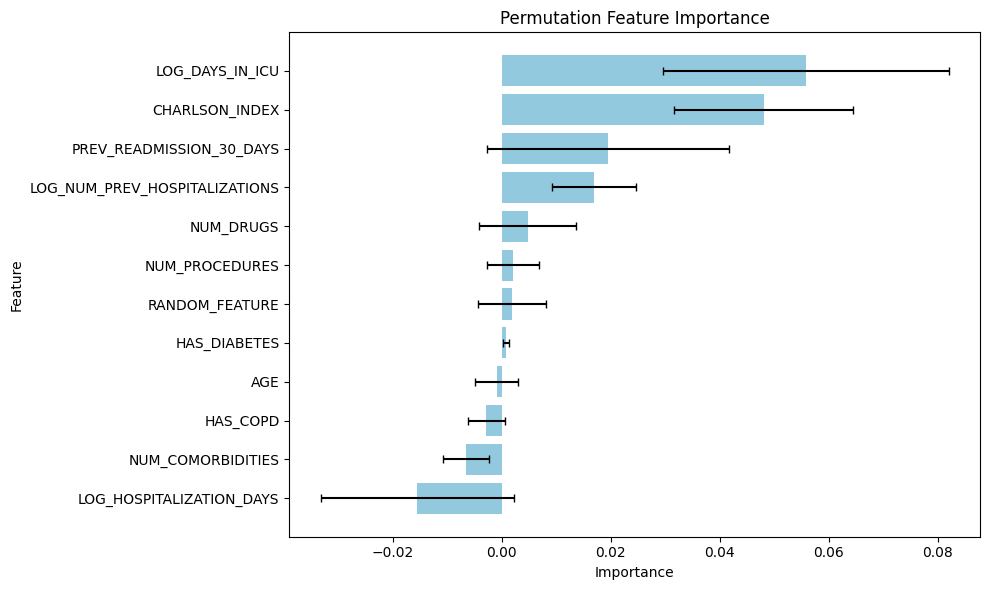

,Feature,Importance,Standard Deviation
0,LOG_DAYS_IN_ICU,0.055786,0.026170
1,CHARLSON_INDEX,0.048048,0.016440
2,PREV_READMISSION_30_DAYS,0.019496,0.022179
3,LOG_NUM_PREV_HOSPITALIZATIONS,0.016958,0.007692
4,NUM_DRUGS,0.004779,0.008926
5,NUM_PROCEDURES,0.002042,0.004721
6,RANDOM_FEATURE,0.001874,0.006178
7,HAS_DIABETES,0.000785,0.000487
8,AGE,-0.000921,0.003920
9,HAS_COPD,-0.002808,0.003380


In [23]:
plot_permutation_importance(random_search_logreg.best_estimator_, X_test_scaled, y_test, n_repeats=50)

### Random Forest

In [24]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

rand_search_params = {
    'n_estimators': [75, 100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}

random_search_rf = RandomizedSearchCV(rf_model, rand_search_params, cv=5, scoring=scoring_search_cv, n_iter=25, random_state=56, n_jobs=-1)
random_search_rf.fit(X_train.astype(float), y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [75, 100, 200, 300]},
                   random_state=56, scoring='roc_auc')

In [25]:
rf_cv_search_results = summarize_search_results(random_search_rf, print_results=True, model_name="Random Forest")

25 candidates of Random forest trained and validated with cross-validation on 5 folds.
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Validation Score - Random forest: 0.629 ± 0.030


In [26]:
y_pred = random_search_rf.predict(X_test)
y_pred_proba = random_search_rf.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_proba)

print("Random Forest model evaluation:")
print("AUC:", roc_auc_rf)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest model evaluation:
AUC: 0.6489970003749532
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       254
           1       0.46      0.27      0.34        84

    accuracy                           0.74       338
   macro avg       0.62      0.58      0.59       338
weighted avg       0.71      0.74      0.71       338



In [27]:
feature_importances = random_search_rf.best_estimator_.feature_importances_
feature_importances_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)
print("Feature importances for Random Forest model:")
print(feature_importances_df)

Feature importances for Random Forest model:
                          feature  importance
4                 LOG_DAYS_IN_ICU    0.153987
2        LOG_HOSPITALIZATION_DAYS    0.145292
11                 RANDOM_FEATURE    0.135783
0                             AGE    0.120933
5                       NUM_DRUGS    0.115191
1                  CHARLSON_INDEX    0.073253
6                  NUM_PROCEDURES    0.071053
8        PREV_READMISSION_30_DAYS    0.051293
3   LOG_NUM_PREV_HOSPITALIZATIONS    0.049174
7               NUM_COMORBIDITIES    0.046387
9                    HAS_DIABETES    0.019550
10                       HAS_COPD    0.018104


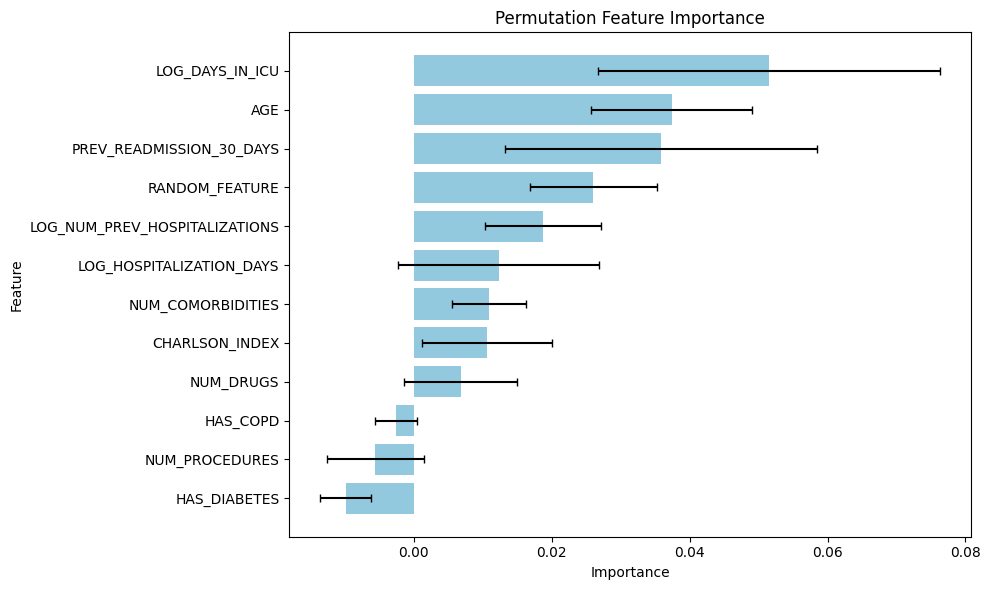

,Feature,Importance,Standard Deviation
0,LOG_DAYS_IN_ICU,0.051512,0.024847
1,AGE,0.037398,0.011713
2,PREV_READMISSION_30_DAYS,0.035865,0.022591
3,RANDOM_FEATURE,0.026028,0.009235
4,LOG_NUM_PREV_HOSPITALIZATIONS,0.018723,0.008361
5,LOG_HOSPITALIZATION_DAYS,0.012299,0.014551
6,NUM_COMORBIDITIES,0.010893,0.005368
7,CHARLSON_INDEX,0.010569,0.009429
8,NUM_DRUGS,0.006792,0.008178
9,HAS_COPD,-0.002574,0.003050


In [28]:
plot_permutation_importance(random_search_rf.best_estimator_, X_test, y_test, scoring='roc_auc', n_repeats=50, random_state=42)

 95%|=================== | 641/676 [00:18<00:00]       

(338, 12, 2)


/tmp/ipykernel_54233/3711069733.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_to_plot, X_test.astype(float),


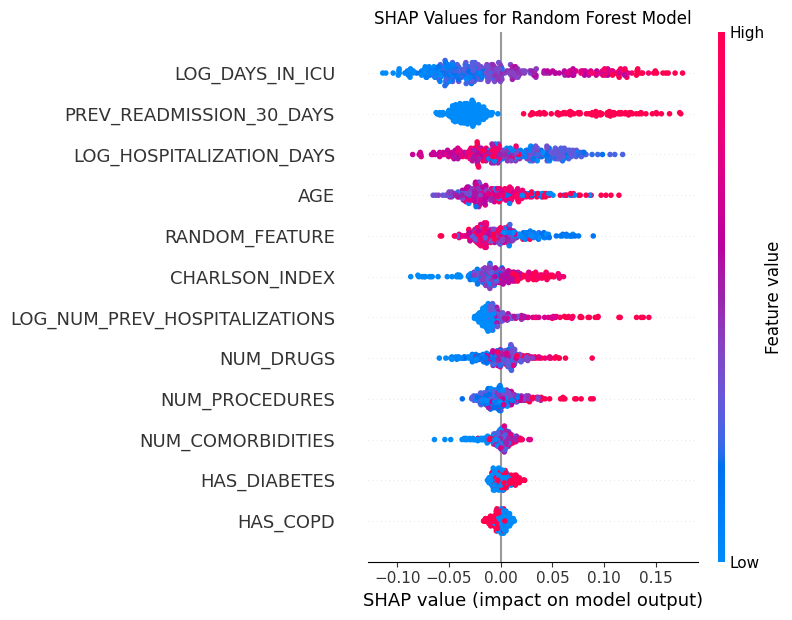

In [29]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(random_search_rf.best_estimator_, X_train.astype(float))
shap_values = explainer.shap_values(X_test.values).astype(np.float64)

print(shap_values.shape)

if shap_values.ndim == 3:  # (n_samples, n_features, n_classes)
    shap_values_to_plot = shap_values[:, :, 1]  # class 1
else:
    shap_values_to_plot = shap_values  # already (n_samples, n_features)

plt.title("SHAP Values for Random Forest Model")
shap.summary_plot(shap_values_to_plot, X_test.astype(float), 
                  feature_names=X_test.columns)
plt.show()

### LightGBM

In [30]:
# Define parameters
lgbm_param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 8, 10],
    'num_leaves': [31, 63, 127],
    'subsample': [0.6, 0.8, 1.0],
}

lgbm = LGBMClassifier(random_state=42, class_weight='balanced')

random_search_lgbm = RandomizedSearchCV(
    lgbm,
    lgbm_param_grid,
    n_iter=10,  # Increase for more thorough search
    scoring=scoring_search_cv,
    cv=5,
    random_state=42,
    n_jobs=-1  # Use all cores
)

# Train the model
random_search_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 268, number of negative: 813
[LightGBM] [Info] Number of positive: 269, number of negative: 813
[LightGBM] [Info] Number of positive: 269, number of negative: 813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 1082, number of used features: 12
[LightGBM] [Info] Number of data points in the train set: 1081, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[Li

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 8, 10],
                                        'n_estimators': [100],
                                        'num_leaves': [31, 63, 127],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc')

In [31]:
lgbm_cv_search_results = summarize_search_results(random_search_lgbm, print_results=True, model_name="LightGBM")

10 candidates of Lightgbm trained and validated with cross-validation on 5 folds.
Best parameters: {'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 100, 'max_depth': 3}
Validation Score - Lightgbm: 0.593 ± 0.040


In [32]:
importances = random_search_lgbm.best_estimator_.feature_importances_
feature_importance_series = pd.Series(importances, index=features)
feature_importance_series.sort_values(ascending=False, inplace=True)
print("Feature importances:")
feature_importance_df = feature_importance_series.reset_index()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df

Feature importances:


,Feature,Importance
0,LOG_DAYS_IN_ICU,125
1,LOG_HOSPITALIZATION_DAYS,106
2,RANDOM_FEATURE,87
3,AGE,80
4,NUM_DRUGS,63
5,CHARLSON_INDEX,38
6,NUM_PROCEDURES,34
7,LOG_NUM_PREV_HOSPITALIZATIONS,20
8,NUM_COMORBIDITIES,20
9,PREV_READMISSION_30_DAYS,20


In [33]:
# Make predictions
y_pred_prob = random_search_lgbm.predict_proba(X_test)[:, 1]
y_pred = random_search_lgbm.predict(X_test)

roc_auc_lgbm = roc_auc_score(y_test, y_pred_prob)
print("LightGBM model evaluation:")
print("AUC:", roc_auc_lgbm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

LightGBM model evaluation:
AUC: 0.6165166854143231
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       254
           1       0.35      0.48      0.40        84

    accuracy                           0.65       338
   macro avg       0.58      0.59      0.58       338
weighted avg       0.69      0.65      0.66       338



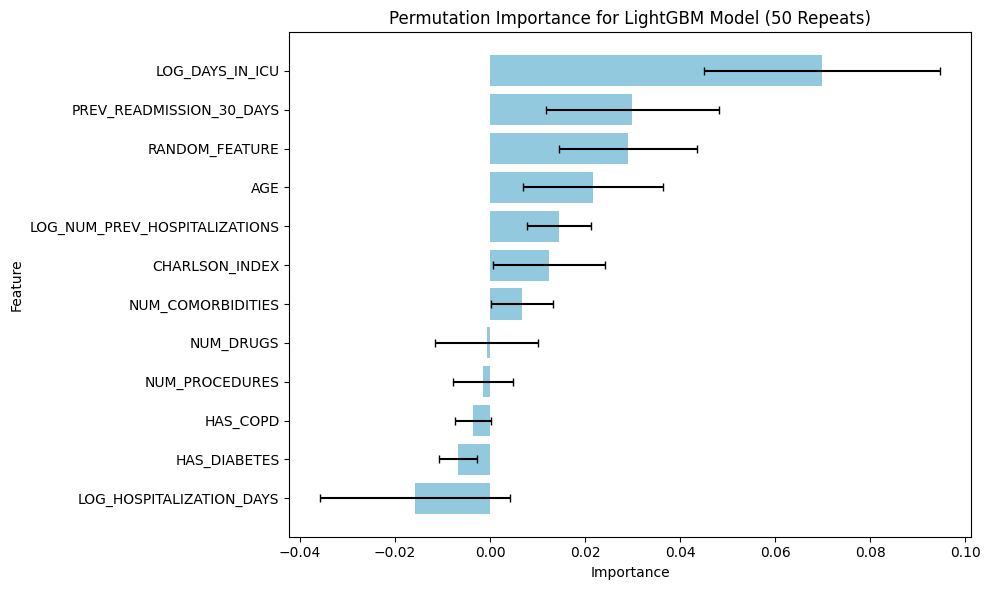

,Feature,Importance,Standard Deviation
0,LOG_DAYS_IN_ICU,0.069782,0.024832
1,PREV_READMISSION_30_DAYS,0.029977,0.018204
2,RANDOM_FEATURE,0.029094,0.014509
3,AGE,0.021707,0.014732
4,LOG_NUM_PREV_HOSPITALIZATIONS,0.014528,0.006771
5,CHARLSON_INDEX,0.012474,0.011788
6,NUM_COMORBIDITIES,0.006713,0.006527
7,NUM_DRUGS,-0.000711,0.010788
8,NUM_PROCEDURES,-0.001434,0.006321
9,HAS_COPD,-0.003550,0.003850


In [34]:
n_repeats = 50  # Number of times to permute each feature
title = f"Permutation Importance for LightGBM Model ({n_repeats} Repeats)"
plot_permutation_importance(random_search_lgbm.best_estimator_, X_test, y_test, scoring='roc_auc', n_repeats=50, random_state=42, title=title)


(338, 12)


/tmp/ipykernel_54233/4040804254.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_to_plot, X_test.astype(float),


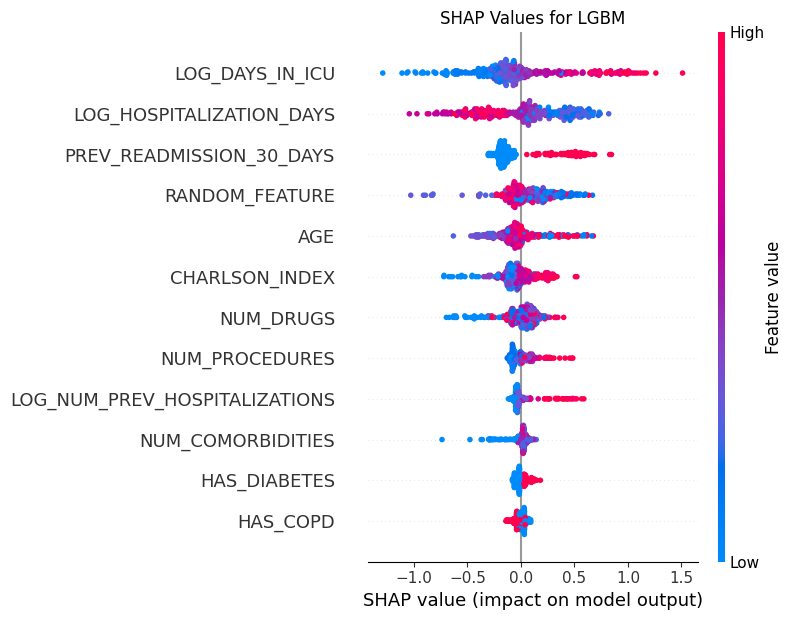

In [35]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(random_search_lgbm.best_estimator_, X_train.astype(float))
shap_values = explainer.shap_values(X_test.values).astype(np.float64)  # shape: (n_samples, n_features)

print(shap_values.shape)

if shap_values.ndim == 3:  # (n_samples, n_features, n_classes)
    shap_values_to_plot = shap_values[:, :, 1]  # class 1
else:
    shap_values_to_plot = shap_values  # already (n_samples, n_features)

plt.title("SHAP Values for LGBM")
shap.summary_plot(shap_values_to_plot, X_test.astype(float), 
                  feature_names=X_test.columns)
plt.show()

## Final Results

In [36]:
random_search_results = [logreg_cv_search_results, rf_cv_search_results, lgbm_cv_search_results]

results = {
    "Model": ["Logistic Regression", "Random Forest", "LightGBM"],
    "Number of Candidates in CV": [cv_results["n_fitted_candidates"] for cv_results in random_search_results],
    "Mean AUC CV": [cv_results["best_score_mean"] for cv_results in random_search_results],
    "Std AUC CV": [cv_results["best_score_std"] for cv_results in random_search_results],
    "Evaluation AUC 30 Days": [roc_auc_logreg, roc_auc_rf, roc_auc_lgbm],
}

results_df = pd.DataFrame(results)
results_df

,Model,Number of Candidates in CV,Mean AUC CV,Std AUC CV,Evaluation AUC 30 Days
0,Logistic Regression,25,0.637088,0.027480,0.597863
1,Random Forest,25,0.629396,0.029886,0.648997
2,LightGBM,10,0.592540,0.040309,0.616517
